In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
import os
import sys
sys.path.insert(0, work)
from illustris_sim import TNGSim
import corrfunc_ls
import tools

### redshift uncertainties

https://github.com/SPHEREx/Public-products

Relationship between redshift and physical distance:

$$
\sigma_z = \frac{dv}{c} = \frac{dz}{1+z} = dx\, \frac{H(x)}{c} \left[ \frac{1}{1+z} \right]
$$

$$
dx = \sigma_z ( 1+z ) \frac{c}{H(x)}
$$

Importantly, this formula returns the distance $dx$ in $\mathrm{Mpc}$, whereas TNG gives their values in $\mathrm{Mpc}/h$.

So we need to convert $dx$ to $\mathrm{Mpc}/h$:

$$
H_0 = 100\,h\,\mathrm{km\,s}^{-1}\mathrm{Mpc}^{-1}
$$
$$
h = \frac{H_0}{100}\mathrm{Mpc\,km}^{-1}\mathrm{s}
$$

In [4]:
h = cosmo.H(0.) / 100 * u.Mpc / u.km * u.s
h

<Quantity 0.6774>

In [5]:
def get_dx(z, sigma_z):
    return sigma_z * (1 + z) * c.c.to(u.km/u.s) / cosmo.H(z) / (h * cu.littleh)

To simulate redshift uncertainty in TNG, take the given tracer positions and move each along the LOS based on a Gaussian draw with $dx$:

In [6]:
def Gaussian_draw(dx, size=None):
    if isinstance(dx, u.Quantity):
        return np.random.normal(loc=0.0, scale=dx.value, size=size) * dx.unit
    else:
        return np.random.normal(loc=0.0, scale=dx, size=size)

Load in a TNG simulation:

In [7]:
redshift = 1.
sim = TNGSim('TNG300-3', redshift=redshift)

Length of the box:

In [8]:
sim.boxsize

<Quantity 205. Mpc / littleh>

Take a $\sigma_z$ from the SPHEREx public product repo (assuming worst redshift uncertainty per bin), load in the corresponding galaxies, and perturb each one along the LOS (take the LOS to be along the $z$ axis):

In [9]:
sigma_z = 0.01
gal_pos = sim.subhalo_pos()[sim.gal_idx('ELG', 'SPHEREx', sigma_z=sigma_z, prints=True)]

ELG number density for SPHEREx at z=1.0: 5.00e-05 (h/Mpc)^3 
target number of subhalos: 430


In [10]:
# center the positions
gal_pos -= np.mean(gal_pos)
print(gal_pos.shape, gal_pos.unit)
gal_pos

(430, 3) Mpc / littleh


<Quantity [[ -50.96949 ,   80.56971 ,  -40.35003 ],
           [  92.95463 ,  -79.78502 ,  -46.138065],
           [ -44.183914,  -87.57867 , -104.38517 ],
           ...,
           [  99.275185,  -93.53019 ,  -69.05858 ],
           [ -69.1585  ,   45.368324,   59.493263],
           [  85.17274 ,   39.47178 ,   76.07342 ]] Mpc / littleh>

In [11]:
dx = get_dx(redshift, sigma_z)
dx

<Quantity 73.46356664 Mpc / littleh>

In [12]:
# what fraction of the box is this?
dx / sim.boxsize

<Quantity 0.35835886>

In [13]:
gal_pos_perturbed = np.copy(gal_pos)
gal_pos_perturbed[:,2] += Gaussian_draw(dx, size=len(gal_pos))

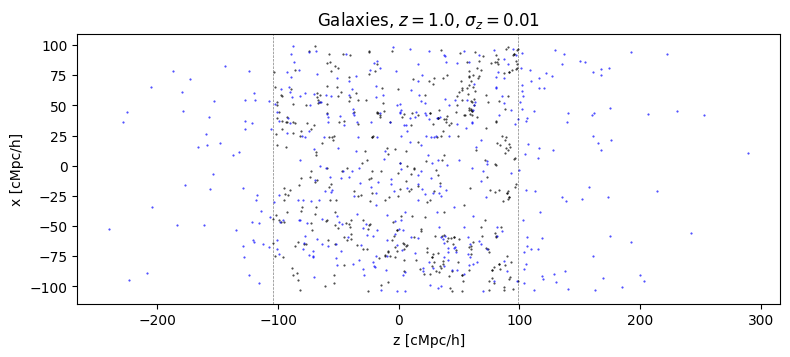

In [14]:
fig, ax = plt.subplots(figsize=(8,5))

kwargs = dict(ls='None', marker='.', ms=1, alpha=0.8)
ax.plot(gal_pos[:,2].value, gal_pos[:,0].value, color='k', **kwargs)
ax.plot(gal_pos_perturbed[:,2].value, gal_pos_perturbed[:,0].value, color='b', **kwargs)
ax.axvline(min(gal_pos[:,2].value), ls='--', color='k', lw=0.5, alpha=0.5)
ax.axvline(max(gal_pos[:,2].value), ls='--', color='k', lw=0.5, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('z [cMpc/h]')
ax.set_ylabel('x [cMpc/h]')
ax.set_title(f'Galaxies, $z={redshift}$, $\sigma_z={sigma_z}$')
fig.tight_layout()

### all redshift uncertainty bins

In [15]:
spherex_sigma_zs = [0.003, 0.01, 0.03, 0.1, 0.2]

ELG number density for SPHEREx at z=1.0: 1.64e-05 (h/Mpc)^3 
target number of subhalos: 141
ELG number density for SPHEREx at z=1.0: 5.00e-05 (h/Mpc)^3 
target number of subhalos: 430
ELG number density for SPHEREx at z=1.0: 2.12e-04 (h/Mpc)^3 
target number of subhalos: 1826
ELG number density for SPHEREx at z=1.0: 7.96e-04 (h/Mpc)^3 
target number of subhalos: 6857
ELG number density for SPHEREx at z=1.0: 7.34e-04 (h/Mpc)^3 
target number of subhalos: 6323


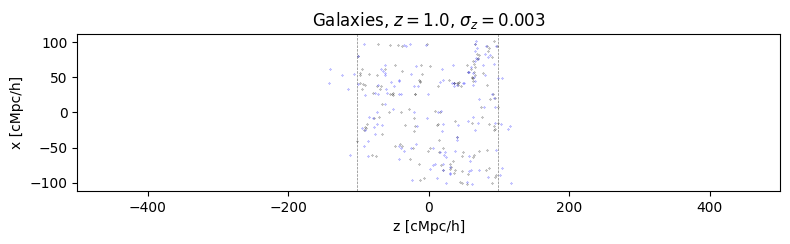

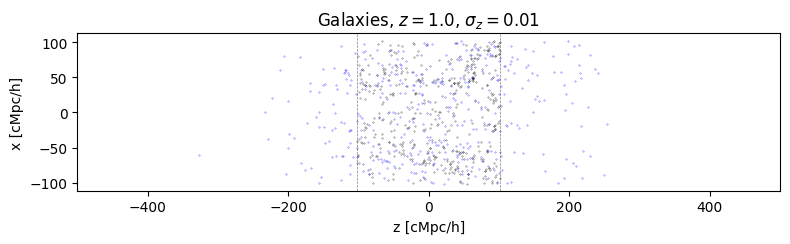

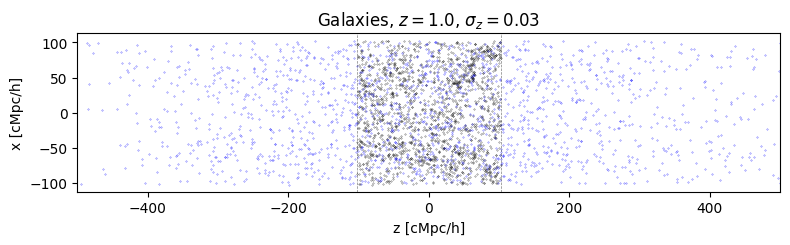

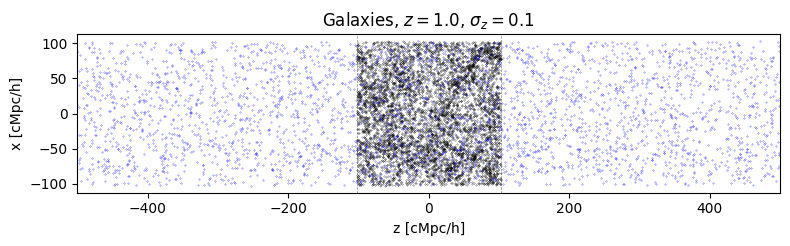

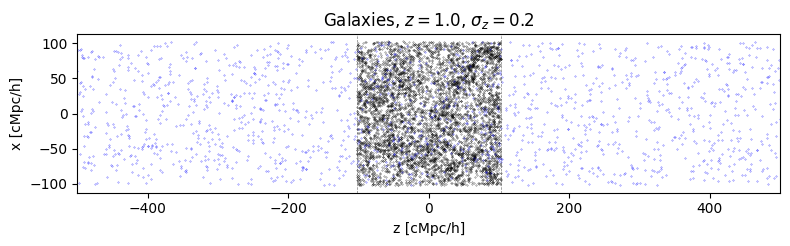

In [16]:
dxs = np.zeros_like(spherex_sigma_zs)
frac_outs = np.zeros_like(dxs)
for i, sigma_z in enumerate(spherex_sigma_zs):
    gal_pos = sim.subhalo_pos()[sim.gal_idx('ELG', 'SPHEREx', sigma_z=sigma_z, prints=True)]
    gal_pos -= sim.boxsize / 2
    dx = get_dx(redshift, sigma_z)
    gal_pos_perturbed = np.copy(gal_pos)
    gal_pos_perturbed[:,2] += Gaussian_draw(dx, size=len(gal_pos))
    
    z = gal_pos[:,2]
    z_err = gal_pos_perturbed[:,2]
    
    dxs[i] = dx.value
    frac_outs[i] = sum([a or b for a, b in zip((z_err < min(z)), (z_err > max(z)))]) / len(gal_pos)
    
    fig, ax = plt.subplots(figsize=(8,5))
    kwargs = dict(ls='None', marker='.', ms=0.5, alpha=0.8)
    ax.plot(gal_pos[:,2].value, gal_pos[:,0].value, color='k', **kwargs)
    ax.plot(gal_pos_perturbed[:,2].value, gal_pos_perturbed[:,0].value, color='b', **kwargs)
    ax.axvline(min(gal_pos[:,2].value), ls='--', color='k', lw=0.5, alpha=0.5)
    ax.axvline(max(gal_pos[:,2].value), ls='--', color='k', lw=0.5, alpha=0.5)
    ax.set_xlim(-500,500)
    ax.set_aspect('equal')
    ax.set_xlabel('z [cMpc/h]')
    ax.set_ylabel('x [cMpc/h]')
    ax.set_title(f'Galaxies, $z={redshift}$, $\sigma_z={sigma_z}$')
    fig.tight_layout()

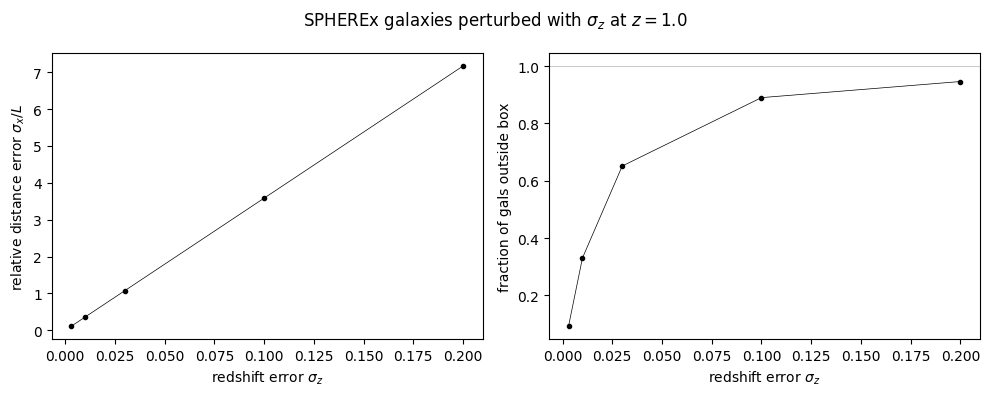

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(spherex_sigma_zs, dxs/sim.boxsize.value, 'k.-', lw=0.5, ms=6)
axs[1].plot(spherex_sigma_zs, frac_outs, 'k.-', lw=0.5, ms=6)
axs[1].axhline(1., color='k', alpha=0.3, lw=0.5)
axs[0].set_ylabel('relative distance error $\sigma_x/L$') #' ($h^{-1}$Mpc)')
axs[1].set_ylabel('fraction of gals outside box')
for ax in axs:
    ax.set_xlabel('redshift error $\sigma_z$')
fig.suptitle(f'SPHEREx galaxies perturbed with $\sigma_z$ at $z=${redshift:.1f}')
fig.tight_layout()